In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn requests torch transformers tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.7.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.2.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.12.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 22.5 

In [2]:
# Data handling libraries
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
import math
from tqdm import tqdm
import re
from collections import Counter

# Natural Language Processing (NLP) libraries
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt

# Scikit-learn modeling libraries
from sklearn.dummy import DummyClassifier # For baseline model
from sklearn.feature_extraction.text import TfidfVectorizer # To convert text to numbers
from sklearn.linear_model import LogisticRegression # The classifier model
from sklearn.metrics import accuracy_score, classification_report # For evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score # For splitting and validating
from sklearn.pipeline import Pipeline # To chain processing step
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from torch.utils.data import Dataset, DataLoader
import torch

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim import Adam
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import copy




from transformers import BertModel, BertTokenizer
from transformers import AutoTokenizer, AutoModel
from transformers import RobertaModel

2025-12-09 02:23:10.434858: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [127]:
MODEL_NAME = "vinai/bertweet-base"   # change if needed

## Utilisation du GPU si dispo

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print("Using device:", device)

Using device: cuda


## Extraction du texte du tweet

In [4]:
def extract_full_text(tweet):
    # Start with the standard 'text' field
    text = tweet['text']
    # Check if the 'extended_tweet.full_text' field exists (is not NaN)
    if not pd.isna(tweet['extended_tweet.full_text']):
        # If it exists, it's the full text, so use it instead
        text = tweet['extended_tweet.full_text']
    return text

In [5]:
data = pd.read_json('../data/raw/train.jsonl', lines=True)
data = json_normalize(data.to_dict(orient='records'))

kaggle_data = pd.read_json('../data/raw/kaggle_test.jsonl', lines=True)
kaggle_data = json_normalize(kaggle_data.to_dict(orient='records'))

In [6]:
# Exemple : extraire le texte visible entre les balises <a>...</a>
def extract_source(source_html):
    match = re.search(r'>(.*?)<', source_html)
    return match.group(1) if match else source_html

# Appliquer la fonction sur la colonne source
data['source_name'] = data['source'].apply(extract_source)
kaggle_data['source_name'] = kaggle_data['source'].apply(extract_source)

## Metadata gestion

In [7]:
main_sources = {
    'Twitter for iPhone', 'Twitter Web App', 'Twitter for Android',
    'Twitter for iPad', 'TweetDeck', 'Hootsuite Inc.', 'dlvr.it',
    'IFTTT', 'Wordpress.com', 'Buffer', 'Echobox'
}

source_stats = data.groupby('source_name').agg(
    total=('label', 'size'),
    sum_labels=('label', 'sum')
)

list_1 = source_stats[
    (source_stats['total'] > 3) &
    (source_stats['sum_labels'] == source_stats['total']) &
    (~source_stats.index.isin(main_sources))
].index.tolist()

list_0 = source_stats[
    (source_stats['total'] > 3) &
    (source_stats['sum_labels'] == 0) &
    (~source_stats.index.isin(main_sources))
].index.tolist()

In [8]:
data['main_source'] = data['source_name'].apply(lambda x: 1 if x in main_sources else 0)
data['others_1'] = 0
data['others_0'] = 0
data['others']  = 0
main_source_dummies = pd.get_dummies(data['source_name'])
main_source_dummies = main_source_dummies[[s for s in main_sources if s in main_source_dummies.columns]]
main_source_dummies = main_source_dummies.astype(int)
data['others_1'] = data['source_name'].apply(lambda x: 1 if x in list_1 else 0)
data['others_0'] = data['source_name'].apply(lambda x: 1 if x in list_0 else 0)
data['others']   = data['source_name'].apply(lambda x: 1 if (x not in main_sources) and (x not in list_1) and (x not in list_0) else 0)
data = pd.concat([data, main_source_dummies], axis=1)

In [134]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)
# print(data.head(3))

In [9]:
kaggle_data['main_source'] = kaggle_data['source_name'].apply(lambda x: 1 if x in main_sources else 0)
kaggle_data['others_1'] = 0
kaggle_data['others_0'] = 0
kaggle_data['others']  = 0
main_source_dummies = pd.get_dummies(kaggle_data['source_name'])
main_source_dummies = main_source_dummies[[s for s in main_sources if s in main_source_dummies.columns]]
main_source_dummies = main_source_dummies.astype(int)
kaggle_data['others_1'] = kaggle_data['source_name'].apply(lambda x: 1 if x in list_1 else 0)
kaggle_data['others_0'] = kaggle_data['source_name'].apply(lambda x: 1 if x in list_0 else 0)
kaggle_data['others']   = kaggle_data['source_name'].apply(lambda x: 1 if (x not in main_sources) and (x not in list_1) and (x not in list_0) else 0)
kaggle_data = pd.concat([kaggle_data, main_source_dummies], axis=1)

In [10]:
def combine_list_columns(df, cols, new_col, mode="merge"):
    """
    Combine plusieurs colonnes contenant des listes.
    
    mode = "merge" → fusionne toutes les listes dans new_col
    mode = "count" → compte le nombre total d'éléments dans les listes
    
    - df : DataFrame
    - cols : liste de noms de colonnes à traiter
    - new_col : nom de la colonne résultante
    """
    results = []
    
    for _, row in df.iterrows():
        if mode == "merge":
            merged = []
            for col in cols:
                val = row.get(col)
                if isinstance(val, list):
                    merged.extend(val)
            results.append(merged)

        elif mode == "count":
            count = 0
            for col in cols:
                val = row.get(col)
                if isinstance(val, list):
                    count += len(val)
            results.append(count)
        
        else:
            raise ValueError("mode must be 'merge' or 'count'")
    
    df[new_col] = results
    return df


In [11]:
data = combine_list_columns(data,['entities.user_mentions', 'extended_tweet.entities.user_mentions'],'all_user_mentions_count', mode ="count") #For all_users_mentions column
data['quoted_status.favorite_count'] = pd.to_numeric(data['quoted_status.favorite_count'], errors='coerce')
data['quoted_status.user.favourites_count'] = pd.to_numeric(data['quoted_status.user.favourites_count'], errors='coerce')

kaggle_data = combine_list_columns(kaggle_data,['entities.user_mentions', 'extended_tweet.entities.user_mentions'],'all_user_mentions_count', mode ="count") #For all_users_mentions column
kaggle_data['quoted_status.favorite_count'] = pd.to_numeric(kaggle_data['quoted_status.favorite_count'], errors='coerce')
kaggle_data['quoted_status.user.favourites_count'] = pd.to_numeric(kaggle_data['quoted_status.user.favourites_count'], errors='coerce')

# Entities

In [12]:
data = combine_list_columns(data,['entities.media', 'extended_tweet.entities.media','extended_entities.media','extended_tweet.extended_entities.media'],'all_media', mode = "merge") 
kaggle_data = combine_list_columns( kaggle_data,['entities.media', 'extended_tweet.entities.media','extended_entities.media','extended_tweet.extended_entities.media'],'all_media', mode = "merge") 

def extract_media_types(media_list):
    if isinstance(media_list, list):
        return {m.get("type") for m in media_list if isinstance(m, dict)}
    return set()

types_series = data['all_media'].apply(extract_media_types)

data['has_photo'] = types_series.apply(lambda t: 1 if "photo" in t else 0)
data['has_video'] = types_series.apply(lambda t: 1 if "video" in t else 0)
data['has_gif']   = types_series.apply(lambda t: 1 if "animated_gif" in t else 0)

types_series_kaggle = kaggle_data['all_media'].apply(extract_media_types)

kaggle_data['has_photo'] = types_series_kaggle.apply(lambda t: 1 if "photo" in t else 0)
kaggle_data['has_video'] = types_series_kaggle.apply(lambda t: 1 if "video" in t else 0)
kaggle_data['has_gif']   = types_series_kaggle.apply(lambda t: 1 if "animated_gif" in t else 0)

In [13]:
data = combine_list_columns(data,['entities.hashtags', 'extended_tweet.entities.hashtags'],'all_hashtags', mode = "merge") 
kaggle_data = combine_list_columns( kaggle_data,['entities.hashtags', 'extended_tweet.entities.hashtags'],'all_hashtags', mode = "merge") 
data_combined = pd.concat([data, kaggle_data], ignore_index=True)

all_hashtags = []
for hashtags_list in data_combined['all_hashtags']:
    if isinstance(hashtags_list, list):
        for hashtag in hashtags_list:
            if isinstance(hashtag, dict) and 'text' in hashtag:
                all_hashtags.append(hashtag['text'].lower())
hashtag_counts = Counter(all_hashtags)  
print("Top 20 hashtags:")
for tag, count in hashtag_counts.most_common(20):
    print(f"{tag}: {count}")

Top 20 hashtags:
covid19: 36666
covid: 7092
coronavirus: 5027
confinement: 3560
couvrefeu: 2314
covid_19: 2238
macron: 2136
vaccin: 2084
covidー19: 2057
covid19france: 1830
vaccination: 1719
france: 1564
confinement2: 962
reconfinement: 944
castex: 901
santé: 885
confinement3: 817
macron20h: 762
vaccins: 759
covid19fr: 738


In [14]:
from collections import Counter

def extract_hashtags(hashtag_list):
    if not isinstance(hashtag_list, list):
        return []
    return [h['text'].lower() for h in hashtag_list if isinstance(h, dict) and 'text' in h]

data['clean_hashtags'] = data['all_hashtags'].apply(extract_hashtags)
kaggle_data['clean_hashtags'] = kaggle_data['all_hashtags'].apply(extract_hashtags)

# 2️⃣ Compter tous les hashtags dans data
all_tags = [tag for tags in data['clean_hashtags'] for tag in tags]
hashtag_counts = Counter(all_tags)

top_tags = [tag for tag, _ in hashtag_counts.most_common(20)]
print("Top 20 hashtags:", top_tags)

for tag in top_tags:
    colname = f"hashtag_{tag}"
    data[colname] = data['clean_hashtags'].apply(lambda tags: int(tag in tags))
    kaggle_data[colname] = kaggle_data['clean_hashtags'].apply(lambda tags: int(tag in tags))

print(data[[f"hashtag_{tag}" for tag in top_tags]].head())
print(kaggle_data[[f"hashtag_{tag}" for tag in top_tags]].head())

Top 20 hashtags: ['covid19', 'covid', 'coronavirus', 'confinement', 'couvrefeu', 'covid_19', 'macron', 'covidー19', 'vaccin', 'covid19france', 'vaccination', 'france', 'reconfinement', 'confinement2', 'castex', 'confinement3', 'santé', 'vaccins', 'macron20h', 'covid19fr']
   hashtag_covid19  hashtag_covid  hashtag_coronavirus  hashtag_confinement  \
0                0              0                    0                    0   
1                0              0                    0                    0   
2                0              0                    0                    0   
3                1              0                    0                    0   
4                0              0                    0                    0   

   hashtag_couvrefeu  hashtag_covid_19  hashtag_macron  hashtag_covidー19  \
0                  0                 0               0                 0   
1                  0                 0               0                 0   
2                  0     

In [15]:
data['favourites_per_status'] = data['user.favourites_count'] / (data['user.statuses_count'] + 1)
data['listed_per_status'] = data['user.listed_count'] / (data['user.statuses_count'] + 1)

kaggle_data['favourites_per_status'] = kaggle_data['user.favourites_count'] / (kaggle_data['user.statuses_count'] + 1)
kaggle_data['listed_per_status'] = kaggle_data['user.listed_count'] / (kaggle_data['user.statuses_count'] + 1)

## Set building

In [16]:
X = data.drop('label', axis=1)
y = data['label']

X_kaggle = kaggle_data

# Apply this function to every row (axis=1) in the training data
X['full_text'] = X.apply(lambda tweet: extract_full_text(tweet), axis=1)
# Apply the same function to the Kaggle test data
X_kaggle['full_text'] = X_kaggle.apply(lambda tweet: extract_full_text(tweet), axis=1)

print(X.shape)

(154914, 237)


In [23]:
# Separate features from the target variable for the training set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% pour le test (à ajuster)
    random_state=42,     # pour la reproductibilité
    stratify=y           # ⚠️ important pour garder la même proportion de classes
)

In [19]:
feature_cols = [
    "user.favourites_count",
    "user.listed_count",
    "user.statuses_count",
    "user.profile_use_background_image",
    "user.default_profile",
    "user.geo_enabled",
    "user.profile_background_tile",
    "all_user_mentions_count",
    "quoted_status.favorite_count",
    "quoted_status.user.favourites_count",
    "others_1",
    "others_0",
    "others",
    "Twitter Web App",
    "Twitter for iPhone",
    "Buffer",
    "Twitter for iPad",
    "Hootsuite Inc.",
    "TweetDeck",
    "IFTTT",
    "dlvr.it",
    "Twitter for Android",
    "Echobox",
    "has_photo",
    "has_video",
    "has_gif",
    "hashtag_covid19",
    "hashtag_coronavirus",
    "hashtag_covidー19",
    "hashtag_covid",
    "hashtag_confinement",
    "hashtag_couvrefeu",
    "hashtag_covid_19",
    "hashtag_macron",
    "hashtag_vaccin",
    "hashtag_covid19france",
    "hashtag_vaccination",
    "hashtag_france",
    "hashtag_reconfinement",
    "hashtag_confinement2",
    "hashtag_castex",
    "hashtag_confinement3",
    "hashtag_santé",
    "hashtag_vaccins",
    "hashtag_macron20h",
    "hashtag_covid19fr",
    "favourites_per_status",
    "listed_per_status"
]

to_remove = [
    "Buffer",
    "Twitter for iPad",
    "IFTTT",
    "dlvr.it",
    "has_gif",
    "hashtag_covid",
    "hashtag_coronavirus",
    "hashtag_confinement",
    "hashtag_couvrefeu",
    "hashtag_covid_19",
    "hashtag_macron",
    "hashtag_covidー19",
    "hashtag_vaccin",
    "hashtag_covid19france",
    "hashtag_vaccination",
    "hashtag_france",
    "hashtag_reconfinement",
    "hashtag_confinement2",
    "hashtag_castex",
    "hashtag_confinement3",
    "hashtag_santé",
    "hashtag_vaccins",
    "hashtag_macron20h",
    "hashtag_covid19fr"
]

# Retirer ces features de feature_cols
feature_cols = [f for f in feature_cols if f not in to_remove]

X_train_feats = X[feature_cols].fillna(0).astype(float)
X_kaggle_feats = X_kaggle[feature_cols].fillna(0).astype(float)

# Ajouter les features textuelles (full_text et user.description) ici
X_train_feats['full_text'] = X['full_text']
X_kaggle_feats['full_text'] = X_kaggle['full_text']
X_train_feats['user.description'] = X['user.description']
X_kaggle_feats['user.description'] = X_kaggle['user.description']

In [20]:

X_train_feats.to_csv('../data/processed/X_train_final.csv', index=False)
X_kaggle_feats.to_csv('../data/processed/X_kaggle_final.csv', index=False)
y.to_csv('../data/processed/y_train_final.csv', index=False)

In [39]:
#Normalisation des features numériques
log_cols = ["user.statuses_count", "user.favourites_count", "user.listed_count","quoted_status.user.favourites_count","quoted_status.favorite_count", "favourites_per_status", "listed_per_status"]

# Colonnes à normaliser "classiquement"
other_cols = [c for c in feature_cols if c not in log_cols]

# Extraire et traiter les colonnes log
X_train_log = np.log1p(X_train[log_cols].fillna(0).astype(float))
X_test_log  = np.log1p(X_test[log_cols].fillna(0).astype(float))
X_kaggle_log = np.log1p(X_kaggle[log_cols].fillna(0).astype(float))

scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log)
X_test_log  = scaler_log.transform(X_test_log)
X_kaggle_log = scaler_log.transform(X_kaggle_log)

# Extraire et traiter les autres colonnes
X_train_other = X_train[other_cols].fillna(0).astype(float)
X_test_other  = X_test[other_cols].fillna(0).astype(float)
X_kaggle_other = X_kaggle[other_cols].fillna(0).astype(float)

scaler_other = StandardScaler()
X_train_other = scaler_other.fit_transform(X_train_other)
X_test_other  = scaler_other.transform(X_test_other)
X_kaggle_other = scaler_other.transform(X_kaggle_other)

# Recomposer les matrices finales
X_train_feats = np.hstack([X_train_log, X_train_other])
X_test_feats  = np.hstack([X_test_log, X_test_other])
X_kaggle_feats = np.hstack([X_kaggle_log, X_kaggle_other])

In [40]:
batch_size = 32 # Original 32
num_workers = 4
max_length = 128 # Original 128
log_every = 20
eval_every_step = 2000
phase1_epochs = 4
phase2_epochs = 1
accumulation_steps = 1  # set >1 if you need effective larger batch
is_model_calculated = False
is_model2_calculated = False

In [41]:
# === Dataset ===
class TweetDataset(Dataset):
    def __init__(self, df, feats_array, tokenizer, max_length, labels=None):
        self.df = df
        self.feats = feats_array
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = labels.values if labels is not None else None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # text = self.df.iloc[idx]["full_text"]
        text = self.df.iloc[idx]["user.description"]
        text = str(text) if text is not None else ""
        feats = torch.tensor(self.feats[idx], dtype=torch.float)

        enc = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )

        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return enc["input_ids"].squeeze(0), enc["attention_mask"].squeeze(0), feats, label
        else:
            return enc["input_ids"].squeeze(0), enc["attention_mask"].squeeze(0), feats


In [42]:
def collate_fn(batch):
    input_ids = torch.stack([b[0] for b in batch])
    attention_mask = torch.stack([b[1] for b in batch])
    feats = torch.stack([b[2] for b in batch])
    if len(batch[0]) == 4:
        labels = torch.stack([b[3] for b in batch])
        return input_ids, attention_mask, feats, labels
    return input_ids, attention_mask, feats


In [ ]:
# Save the datasets as csv for future use

data.to_csv('../data/processed/X_train_final.csv', index=False)
kaggle_data.to_csv('../data/processed/X_kaggle_final.csv', index=False)
y_train.to_csv('../data/processed/y_train_final.csv', index=False)

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [29]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
bert_model = AutoModel.from_pretrained(MODEL_NAME)

NameError: name 'MODEL_NAME' is not defined

In [30]:
train_ds = TweetDataset(X_train, X_train_feats, tokenizer, max_length, labels=y_train)
test_ds  = TweetDataset(X_test, X_test_feats, tokenizer, max_length, labels=y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

NameError: name 'tokenizer' is not defined

In [151]:
class BertweetWithFeatures(nn.Module):
    def __init__(self, bert_model, metadata_dim, num_classes,
                 hidden_dim=768, metadata_mlp_dims=(128,64), dropout=0.2):
        super().__init__()
        self.bert = bert_model  # BERTweet from HF

        # MLP pour les features
        self.meta_mlp = nn.Sequential(
            nn.Linear(metadata_dim, metadata_mlp_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(metadata_mlp_dims[0], metadata_mlp_dims[1]),
            nn.ReLU(),
        )

        fusion_dim = hidden_dim + metadata_mlp_dims[1]
        # Fusion : [CLS] + metadata
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes),
        )
        #self.classifier = nn.Sequential( nn.Linear(hidden_dim + metadata_mlp_dims[1], 256), nn.ReLU(), nn.Dropout(dropout), nn.Linear(256, num_classes) ) ------> 1st vesrion

    def forward(self, input_ids, attention_mask, metadata):
        bert_out = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls = bert_out.last_hidden_state[:, 0, :]  # CLS token
        meta_embed = self.meta_mlp(metadata)
        fused = torch.cat([cls, meta_embed], dim=1)
        logits = self.classifier(fused)
        return logits


In [152]:
# Robust metadata_dim inference + model instantiation
import inspect

def infer_metadata_dim():
    # 1) Prefer already-scaled numpy arrays (common variable name in your notebook)
    if 'X_train_feats' in globals():
        try:
            dim = int(X_train_feats.shape[1])
            print(f"[INFO] metadata_dim inferred from X_train_feats: {dim}")
            return dim
        except Exception:
            pass

    # 2) If you kept feature_cols list, use its length
    if 'feature_cols' in globals():
        try:
            dim = int(len(feature_cols))
            print(f"[INFO] metadata_dim inferred from feature_cols length: {dim}")
            return dim
        except Exception:
            pass

    # 3) If you still have X_train dataframe (or similarly named), try to read it
    for candidate in ['X_train', 'train_df', 'X', 'data']:
        if candidate in globals():
            try:
                df = globals()[candidate]
                # If it's a DataFrame and feature_cols exists, use that
                if 'feature_cols' in globals():
                    dim = int(df[feature_cols].fillna(0).shape[1])
                    print(f"[INFO] metadata_dim inferred from {candidate}[feature_cols]: {dim}")
                    return dim
                # Otherwise try to infer numeric columns count
                numeric_cols = df.select_dtypes(include=['number']).shape[1]
                if numeric_cols > 0:
                    print(f"[INFO] metadata_dim inferred from numeric cols of {candidate}: {numeric_cols}")
                    return int(numeric_cols)
            except Exception:
                pass

    # 4) If you have a precomputed X_train numpy array variable with a different name, try to detect it
    for name, val in globals().items():
        if isinstance(val, (list, tuple, np.ndarray)):
            try:
                arr = np.asarray(val)
                if arr.ndim == 2 and arr.shape[0] == (globals().get('X_train', globals().get('train_df', None)).shape[0] if 'X_train' in globals() or 'train_df' in globals() else arr.shape[0]):
                    # cautious check, but skip automatic selection to avoid false positives
                    pass
            except Exception:
                pass

    # 5) Fallback: ask the user to set metadata_dim manually (but we won't prompt; set a sane default)
    default_dim = globals().get('metadata_dim_manual', None)
    if default_dim is not None:
        print(f"[INFO] metadata_dim taken from metadata_dim_manual: {default_dim}")
        return int(default_dim)

    # Final fallback: try length of feature_cols if present, else raise informative error
    if 'feature_cols' in globals():
        dim = int(len(feature_cols))
        print(f"[INFO fallback] metadata_dim inferred from feature_cols length: {dim}")
        return dim

    raise RuntimeError(
        "Cannot infer metadata_dim automatically. Please set `metadata_dim_manual = <int>` "
        "or ensure one of these exists in the notebook: X_train_feats (np.array), feature_cols (list), "
        "or a DataFrame X_train/train_df with the feature columns."
    )

# Use the inference function to create metadata_dim and instantiate model
metadata_dim = infer_metadata_dim()

[INFO] metadata_dim inferred from X_train_feats: 24


In [153]:
# Instantiate model (adjust class name / args if you changed them)
model = model = BertweetWithFeatures(
    bert_model=bert_model,
    metadata_dim=metadata_dim,
    num_classes=2,
    hidden_dim=768,
    metadata_mlp_dims=(128,64),
    dropout=0.2 # original 0.2
).to(device)


print(f"[OK] Model instantiated with metadata_dim={metadata_dim}")

[OK] Model instantiated with metadata_dim=24


In [154]:
criterion = nn.CrossEntropyLoss()

def evaluate(model, loader):
    model.eval()
    total = 0
    correct = 0
    loss_sum = 0.0
    with torch.no_grad():
        for input_ids, attention_mask, metadata_t, labels in loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            metadata_t = metadata_t.to(device)
            labels = labels.to(device)

            logits = model(input_ids, attention_mask, metadata_t)
            loss = criterion(logits, labels)
            loss_sum += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return loss_sum / len(loader), correct / total

def sanity_check_overfit_batch(model, loader, n_steps=200, lr=1e-3):
    # try to overfit a single batch (sanity)
    model.train()
    it = iter(loader)
    input_ids, attention_mask, metadata_t, labels = next(it)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    metadata_t = metadata_t.to(device)
    labels = labels.to(device)
    opt = AdamW(model.parameters(), lr=lr)
    for i in range(n_steps):
        opt.zero_grad()
        logits = model(input_ids, attention_mask, metadata_t)
        loss = criterion(logits, labels)
        loss.backward()
        opt.step()
        if i % 20 == 0:
            print(f"step {i} loss {loss.item():.4f}")


In [155]:
# === PHASE 1: Freeze BERT, train MLP + head only ===
def set_requires_grad(model, pattern_requires=None):
    # pattern_requires: list of substrings that should require grad
    for name, p in model.named_parameters():
        if pattern_requires is None:
            p.requires_grad = True
        else:
            p.requires_grad = any([pat in name for pat in pattern_requires])

if not is_model_calculated:
    # freeze all bert params
    for n,p in model.named_parameters():
        if n.startswith("bert."):
            p.requires_grad = False
        else:
            p.requires_grad = True

    # optimizer: only parameters that require grad
    opt_group = [p for p in model.parameters() if p.requires_grad]
    optimizer = AdamW(opt_group, lr=3e-4, eps=1e-8)
    num_training_steps = len(train_loader) * phase1_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*num_training_steps),
                                                num_training_steps=num_training_steps)

    # logging containers
    train_step_losses = []
    train_step_accs = []
    valid_losses = []
    valid_accs = []
    steps = []
    val_steps = []

    global_step = 0
    best_val_acc = 0.0
    best_model_state = None

    print("=== START PHASE 1 (freeze BERT) ===")
    for epoch in range(phase1_epochs):
        model.train()
        correct = 0
        total = 0
        loop = tqdm(train_loader, desc=f"Phase1 Epoch {epoch+1}")
        for input_ids, attention_mask, metadata_t, labels in loop:
            global_step += 1
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            metadata_t = metadata_t.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask, metadata_t)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if global_step % log_every == 0:
                train_step_losses.append(loss.item())
                train_step_accs.append(correct/total)
                steps.append(global_step)
                loop.set_postfix(loss=float(loss), acc=float(correct/total))

            if global_step % eval_every_step == 0:
                vloss, vacc = evaluate(model, test_loader )
                valid_losses.append(vloss)
                valid_accs.append(vacc)
                val_steps.append(global_step)
                # save best
                if vacc > best_val_acc:
                    best_val_acc = vacc
                    best_model_state = copy.deepcopy(model.state_dict())

        # end epoch validation (optional)
        vloss, vacc = evaluate(model, test_loader )
        valid_losses.append(vloss)
        valid_accs.append(vacc)
        val_steps.append(global_step)
        if vacc > best_val_acc:
            best_val_acc = vacc
            best_model_state = copy.deepcopy(model.state_dict())
        print(f"Phase1 Epoch {epoch+1} — val loss {vloss:.4f} val acc {vacc:.4f}")

    # save best phase1
    if best_model_state is not None:
        torch.save(best_model_state, "bertweet_desc_phase1.pt")
else:
    # === LOAD PHASE 1 MODEL ===
    print("=== Loading pretrained Phase 1 model ===")
    # Charger les poids
    model.load_state_dict(torch.load("bertweet_desc_phase1.pt", map_location=device))
    model.eval()

=== START PHASE 1 (freeze BERT) ===


Phase1 Epoch 1: 100%|██████████| 3873/3873 [06:20<00:00, 10.17it/s, acc=0.797, loss=0.429] 


Phase1 Epoch 1 — val loss 0.3838 val acc 0.8311


Phase1 Epoch 2: 100%|██████████| 3873/3873 [07:30<00:00,  8.60it/s, acc=0.832, loss=0.408]  


Phase1 Epoch 2 — val loss 0.3758 val acc 0.8344


Phase1 Epoch 3: 100%|██████████| 3873/3873 [07:30<00:00,  8.60it/s, acc=0.836, loss=0.297]  


Phase1 Epoch 3 — val loss 0.3738 val acc 0.8367


Phase1 Epoch 4: 100%|██████████| 3873/3873 [07:32<00:00,  8.55it/s, acc=0.842, loss=0.271]  


Phase1 Epoch 4 — val loss 0.3619 val acc 0.8406


In [156]:
# start from end of phase1
model2 = copy.deepcopy(model)  
if not is_model2_calculated:
    # === PHASE 2: unfreeze layers 10 & 11 of BERT, LR differential ===
    print("=== START PHASE 2 (unfreeze last 2 layers) ===")
       
    # ensure BERT params frozen by default
    for n,p in model2.named_parameters():
        p.requires_grad = False

    # Unfreeze last 2 encoder layers and classifier/head and metadata MLP
    for n,p in model2.named_parameters():
        if ("bert.encoder.layer.10" in n) or ("bert.encoder.layer.11" in n):
            p.requires_grad = True
        if ("head" in n) or ("metadata_mlp" in n):
            p.requires_grad = True
        # Note: classifier weights are in head, so already covered

    # show trainable params
    trainable_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
    print(f"Trainable parameters (phase 2): {trainable_params}")
    # for n,p in model2.named_parameters():
    #     if p.requires_grad:
    #         print("TRAIN:", n)

    # Parameter groups with different LRs:
    param_groups = [
        {"params": [p for n,p in model2.named_parameters() if p.requires_grad and ("bert.encoder.layer.10" in n or "bert.encoder.layer.11" in n)],
        "lr": 2e-5},
        {"params": [p for n,p in model2.named_parameters() if p.requires_grad and ("metadata_mlp" in n)],
        "lr": 1e-5},
        {"params": [p for n,p in model2.named_parameters() if p.requires_grad and ("head" in n)],
        "lr": 1e-5},
    ]

    optimizer = AdamW(param_groups, eps=1e-8,weight_decay=0.01)
    num_training_steps = len(train_loader) * phase2_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.05*num_training_steps),
                                                num_training_steps=num_training_steps)

    # reset logging for phase2
    phase2_train_losses = []
    phase2_train_accs = []
    phase2_valid_losses = []
    phase2_valid_accs = []
    phase2_steps = []
    phase2_val_steps = []

    global_step = 0
    best_val_acc_phase2 = 0.0
    best_model_state_phase2 = None

    for epoch in range(phase2_epochs):
        model2.train()
        correct = 0
        total = 0
        loop = tqdm(train_loader, desc=f"Phase2 Epoch {epoch+1}")
        for input_ids, attention_mask, metadata_t, labels in loop:
            global_step += 1

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            metadata_t = metadata_t.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model2(input_ids, attention_mask, metadata_t)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if global_step % log_every == 0:
                phase2_train_losses.append(loss.item())
                phase2_train_accs.append(correct/total)
                phase2_steps.append(global_step)
                loop.set_postfix(loss=float(loss), acc=float(correct/total))

            if global_step % eval_every_step == 0:
                vloss, vacc = evaluate(model2, test_loader )
                phase2_valid_losses.append(vloss)
                phase2_valid_accs.append(vacc)
                phase2_val_steps.append(global_step)
                if vacc > best_val_acc_phase2:
                    best_val_acc_phase2 = vacc
                    best_model_state_phase2 = copy.deepcopy(model2.state_dict())

        # end of epoch validation
        vloss, vacc = evaluate(model2, test_loader )
        phase2_valid_losses.append(vloss)
        phase2_valid_accs.append(vacc)
        phase2_val_steps.append(global_step)
        if vacc > best_val_acc_phase2:
            best_val_acc_phase2 = vacc
            best_model_state_phase2 = copy.deepcopy(model2.state_dict())
        print(f"Phase2 Epoch {epoch+1} — val loss {vloss:.4f} val acc {vacc:.4f}")

    # Save best phase2
    if best_model_state_phase2 is not None:
        torch.save(best_model_state_phase2, "bertweet_desc_phase2")
else:
        # === LOAD PHASE 2 MODEL ===
        print("=== Loading pretrained Phase 2 model ===")
        # Charger les poids
        model2.load_state_dict(torch.load("best_phase2_desc.pt", map_location=device))
        model2.eval()

=== START PHASE 2 (unfreeze last 2 layers) ===
Trainable parameters (phase 2): 14175744


Phase2 Epoch 1:   0%|          | 0/3873 [00:00<?, ?it/s]

Phase2 Epoch 1: 100%|██████████| 3873/3873 [07:44<00:00,  8.34it/s, acc=0.84, loss=0.251]    


Phase2 Epoch 1 — val loss 0.3446 val acc 0.8505


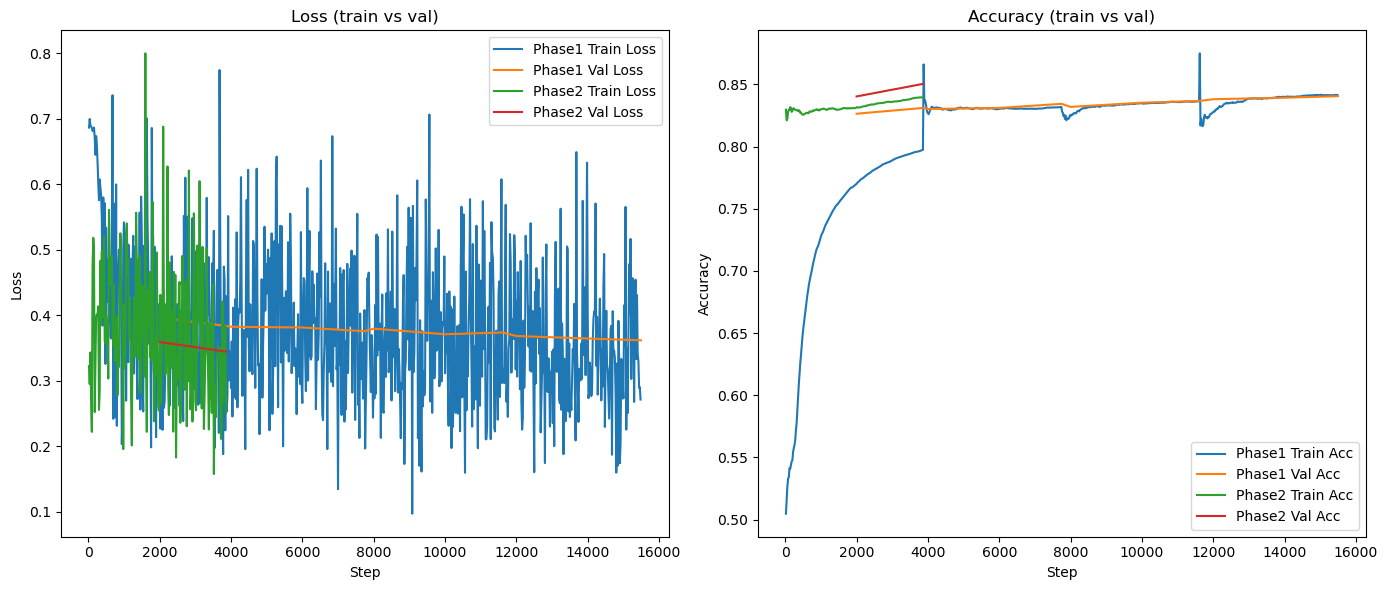

In [157]:
# === PLOTTING combined train & val (aligned on steps) ===
plt.figure(figsize=(14,6))

# LOSS
plt.subplot(1,2,1)
plt.plot(steps, train_step_losses, label="Phase1 Train Loss")
plt.plot(val_steps, valid_losses, label="Phase1 Val Loss")
plt.plot(phase2_steps, phase2_train_losses, label="Phase2 Train Loss")
plt.plot(phase2_val_steps, phase2_valid_losses, label="Phase2 Val Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss (train vs val)")

# ACCURACY
plt.subplot(1,2,2)
plt.plot(steps, train_step_accs, label="Phase1 Train Acc")
plt.plot(val_steps, valid_accs, label="Phase1 Val Acc")
plt.plot(phase2_steps, phase2_train_accs, label="Phase2 Train Acc")
plt.plot(phase2_val_steps, phase2_valid_accs, label="Phase2 Val Acc")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy (train vs val)")

plt.tight_layout()
plt.show()

In [158]:
# === FINAL TEST METRICS ON best phase2 (if exists) ===
if best_model_state_phase2 is not None:
    model2.load_state_dict(best_model_state_phase2)
    test_loss, test_acc = evaluate(model2, test_loader)
    print(f"Final Test — loss: {test_loss:.4f}, acc: {test_acc:.4f}")
else:
    print("No best model saved during phase2.")

Final Test — loss: 0.3446, acc: 0.8505


In [159]:
#=== Optional: sanity check (uncomment to run) ===
# sanity_check_overfit_batch(model, train_loader, n_steps=100, lr=1e-3)

# Stats on labels

In [170]:
def get_predictions_df(model, loader, X_df):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, metadata_t, labels in loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            metadata_t = metadata_t.to(device)

            logits = model(input_ids, attention_mask, metadata_t)
            probs = torch.softmax(logits, dim=1)

            all_preds.extend(probs.argmax(dim=1).cpu().numpy())
            all_probs.extend(probs[:,1].cpu().numpy())   # prob d'être classe 1
            all_labels.extend(labels.cpu().numpy())

    # Construction DataFrame
    df = X_df.copy().reset_index(drop=True)
    df["y_true"] = all_labels
    df["y_pred"] = all_preds
    df["prob_1"] = all_probs
    df["prob_0"] = 1 - df["prob_1"]

    return df


In [171]:
df_preds = get_predictions_df(model2, test_loader, X_test)
df_preds.head()

,in_reply_to_status_id_str,in_reply_to_status_id,created_at,in_reply_to_user_id_str,source,quoted_status_id,retweet_count,retweeted,geo,filter_level,...,hashtag_vaccins,hashtag_macron20h,hashtag_covid19fr,favourites_per_status,listed_per_status,full_text,y_true,y_pred,prob_1,prob_0
0,NaN,NaN,2021-04-01 17:15:18+00:00,NaN,"<a href=""http://twitter.com/download/android"" ...",1.377669e+18,0,False,NaN,low,...,0,0,0,1.299931,0.000850,Vla autre chose 😓,1,1,0.937115,0.062885
1,NaN,NaN,2021-03-30 14:08:33+00:00,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,0,False,NaN,low,...,0,0,0,0.043220,0.009460,La lutte contre le Covid a mis en lumière un a...,1,1,0.943047,0.056953
2,1.325137e+18,1.325137e+18,2020-11-07 18:18:17+00:00,1.151660e+18,"<a href=""http://twitter.com/download/android"" ...",NaN,0,False,NaN,low,...,0,0,0,1.550000,0.000000,@brunolp30 @imagique_media Le virus se transme...,0,0,0.009746,0.990254
3,NaN,NaN,2021-02-01 12:49:19+00:00,NaN,"<a href=""http://twitter.com/download/iphone"" r...",1.356190e+18,0,False,NaN,low,...,0,0,0,3.665665,0.000000,aïe aïe aïe le rhey,0,0,0.091556,0.908444
4,1.361730e+18,1.361730e+18,2021-02-16 17:52:58+00:00,5.449259e+08,"<a href=""http://twitter.com/download/iphone"" r...",NaN,0,False,NaN,low,...,0,0,0,1.253153,0.000901,@LkerCarradec @Saskia_2020 @anthonydufour Voil...,0,0,0.038753,0.961247


In [172]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_preds["y_true"], df_preds["y_pred"])
tn, fp, fn, tp = cm.ravel()

print("TN:", tn)
print("FP:", fp)
print("FN:", fn)
print("TP:", tp)

print("\nFP rate:", fp / (fp + tn))
print("FN rate:", fn / (fn + tp))

TN: 14695
FP: 1840
FN: 2792
TP: 11656

FP rate: 0.11127910492893861
FN rate: 0.19324473975636766


## Kaggle time !

In [160]:
kaggle_ds = TweetDataset(X_kaggle, X_kaggle_feats, tokenizer, max_length, labels= None)
kaggle_loader = DataLoader(kaggle_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [161]:
model2.eval()
kaggle_predictions = []
kaggle_probabilities = []

with torch.no_grad():
    for input_ids, attention_mask, metadata_t in tqdm(kaggle_loader, desc="Kaggle Inference"):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        metadata_t = metadata_t.to(device)

        # Sortie brute du modèle
        logits = model2(input_ids, attention_mask, metadata_t)  # [batch_size, num_classes]
        probs = torch.softmax(logits, dim=1)  # [batch_size, num_classes]
        preds = probs.argmax(dim=1).cpu().numpy()  # convertit en numpy
        kaggle_predictions.extend(preds)

        kaggle_probabilities.extend(probs.cpu().numpy())  # shape = [batch_size, num_classes]


Kaggle Inference:   0%|          | 0/3231 [00:00<?, ?it/s]

Kaggle Inference: 100%|██████████| 3231/3231 [04:11<00:00, 12.83it/s]


In [162]:
X_kaggle['prob_0'] = [p[0] for p in kaggle_probabilities]
X_kaggle['prob_1'] = [p[1] for p in kaggle_probabilities]

# 2️⃣ Moyenne des probabilités par utilisateur
df_user_avg = X_kaggle.groupby('user.created_at')[['prob_0', 'prob_1']].mean().reset_index()

# 3️⃣ Déterminer le label final par argmax de la moyenne des probabilités
df_user_avg['final_label'] = df_user_avg[['prob_0', 'prob_1']].idxmax(axis=1).apply(lambda x: int(x[-1]))

X_kaggle = X_kaggle.merge(
    df_user_avg[['user.created_at', 'prob_0', 'prob_1', 'final_label']],
    on='user.created_at',
    suffixes=('', '_user_avg')
)


In [163]:
# submission_df = pd.DataFrame({
#     "ID": X_kaggle["challenge_id"],
#     "Prediction": kaggle_predictions
# })

# submission_df.to_csv("submission_bert_desc.csv", index=False)
# print("Fichier sauvegardé : submission_bert_desc.csv")


In [164]:
submission_df = pd.DataFrame({
    "ID": X_kaggle["challenge_id"],
    "Prediction": X_kaggle["final_label"]
})

submission_df.to_csv("submission_bert_desc_user_avg.csv", index=False)
print("Fichier sauvegardé : submission_bert_desc_user_avg.csv")


Fichier sauvegardé : submission_bert_desc_user_avg.csv


In [165]:
#Compter le nombre de lignes qu'utiliser final_label change par rapport à kaggle_predictions
num_differences = (X_kaggle['final_label'] != kaggle_predictions).sum()
print(f"Nombre de différences entre kaggle_predictions et final_label: {num_differences}")

Nombre de différences entre kaggle_predictions et final_label: 3391


In [166]:
print(X_train[feature_cols].columns.tolist())
print(X_kaggle[feature_cols].columns.tolist())

['user.favourites_count', 'user.listed_count', 'user.statuses_count', 'user.profile_use_background_image', 'user.default_profile', 'user.geo_enabled', 'user.profile_background_tile', 'all_user_mentions_count', 'quoted_status.favorite_count', 'quoted_status.user.favourites_count', 'others_1', 'others_0', 'others', 'Twitter Web App', 'Twitter for iPhone', 'Hootsuite Inc.', 'TweetDeck', 'Twitter for Android', 'Echobox', 'has_photo', 'has_video', 'hashtag_covid19', 'favourites_per_status', 'listed_per_status']
['user.favourites_count', 'user.listed_count', 'user.statuses_count', 'user.profile_use_background_image', 'user.default_profile', 'user.geo_enabled', 'user.profile_background_tile', 'all_user_mentions_count', 'quoted_status.favorite_count', 'quoted_status.user.favourites_count', 'others_1', 'others_0', 'others', 'Twitter Web App', 'Twitter for iPhone', 'Hootsuite Inc.', 'TweetDeck', 'Twitter for Android', 'Echobox', 'has_photo', 'has_video', 'hashtag_covid19', 'favourites_per_status

# Shap values

In [167]:
from captum.attr import IntegratedGradients

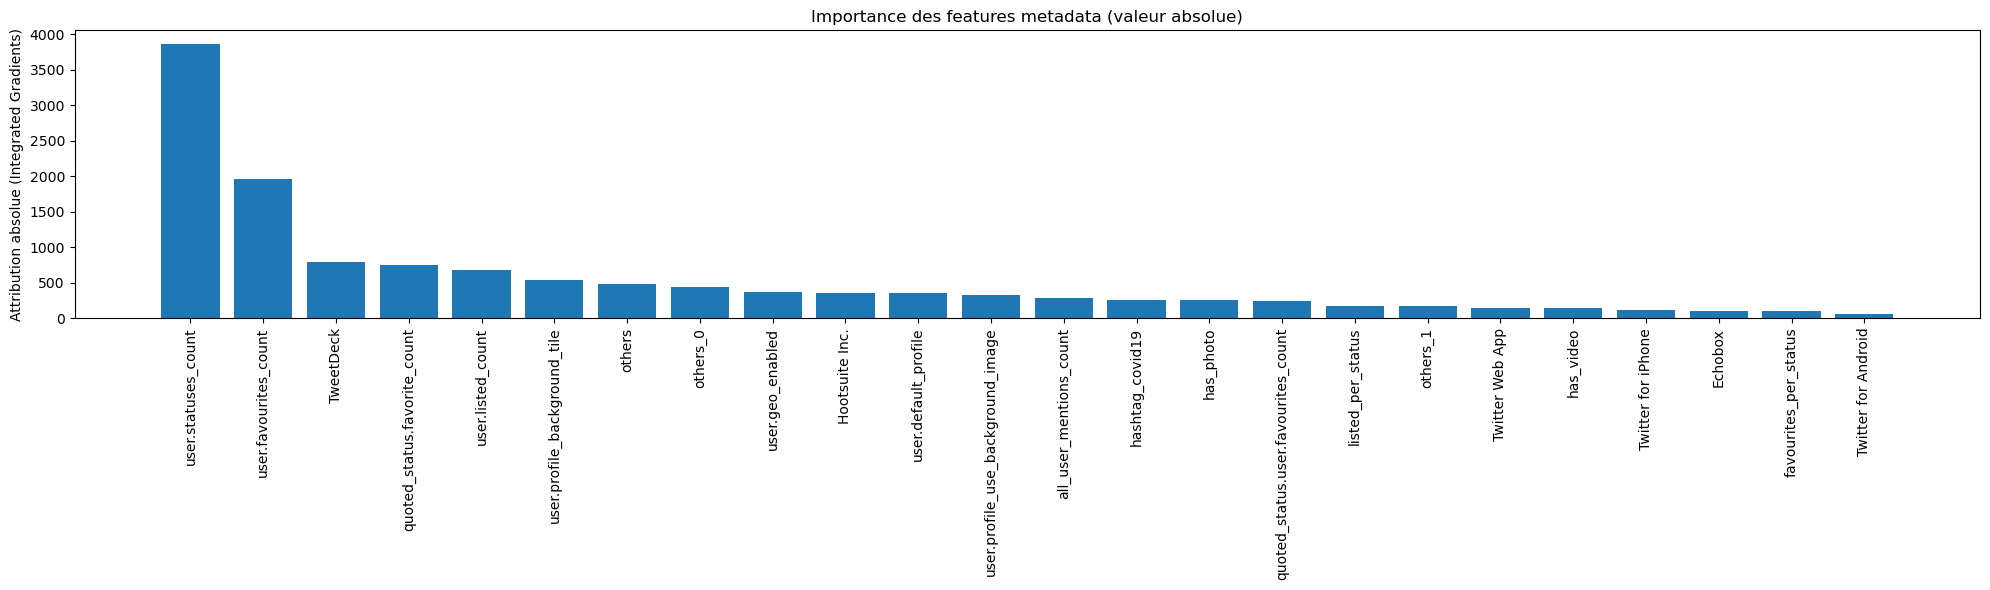

In [168]:
import torch
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model2.eval()
model2.to(device)

# -------------------------------
# Préparer un batch test
# -------------------------------
batch_size = 5000
test_batch = next(iter(DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)))
metadata = test_batch[2].float().to(device)
labels = test_batch[3]

# -------------------------------
# Créer un wrapper qui prend uniquement metadata
# -------------------------------
class MetadataOnlyWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.meta_mlp = model.meta_mlp
        self.classifier = model.classifier
        self.hidden_dim = model.bert.config.hidden_size  # taille de CLS
    def forward(self, metadata):
        batch_size = metadata.shape[0]
        cls_placeholder = torch.zeros(batch_size, self.hidden_dim).to(metadata.device)  # CLS fictif
        meta_emb = self.meta_mlp(metadata)
        fused = torch.cat([cls_placeholder, meta_emb], dim=1)
        return self.classifier(fused)

wrapper_model = MetadataOnlyWrapper(model2).to(device)
wrapper_model.eval()

# -------------------------------
# IntegratedGradients sur metadata
# -------------------------------
ig = IntegratedGradients(wrapper_model)
target_class = labels[0].item()  # expliquer la vraie classe du 1er exemple

attributions = ig.attribute(metadata, target=target_class, n_steps=50)
metadata_attr = attributions  # shape [batch_size, metadata_dim]

# -------------------------------
# Visualiser les contributions des features
# -------------------------------
metadata_dim = metadata.shape[1]
metadata_attr_sum = torch.abs(metadata_attr).sum(dim=0).cpu().numpy()  

feature_names = feature_cols  # vrais noms

# Tri décroissant pour mettre les features les plus influentes à gauche
sorted_idx = np.argsort(metadata_attr_sum)[::-1]

plt.figure(figsize=(20,6))
plt.bar(np.array(feature_names)[sorted_idx], metadata_attr_sum[sorted_idx])
plt.xticks(rotation=90)
plt.ylabel("Attribution absolue (Integrated Gradients)")
plt.title("Importance des features metadata (valeur absolue)")
plt.tight_layout()
plt.show()

In [169]:
#Afficher les metadatas avec moins de 100 dans metadata_attr_sum
print("Features with low importance (<100):")
for i in range(metadata_dim):
    if metadata_attr_sum[i] < 100:
        print(f"{feature_names[i]}")


Features with low importance (<100):
Twitter for Android
Echobox
favourites_per_status
